In [1]:
from tensorflow.keras.datasets import *  # Assuming you use specific datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from qkeras import *  # Assuming you need all components from qkeras
from qkeras.codebook import *  # Same assumption as above

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import numpy as np
import os
import pandas as pd




In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

def get_data(file_path, test_size=0.2, sample_size=1.0, random_state=42, normalize=True):
    # Load the dataset
    data1 = pd.read_csv(r'\Users\oscar\OneDrive\Documents\Year4_Project\QNN_Ideas\New_prams_1.csv')
    columns_to_keep = ['label' ,'L1_centre_sum', 'L1_wide_centre_sum', 'L1_wider_centre_sum','L2_centre_sum', 'L2_wide_centre_sum', 'L2_spread_sum', 'L2_vertical_sum', 'L3_centre_sum', 'Had_centre_sum', 'Had_peripheral_sum', 'Had_out_sum', 'TOB_eta']
    data = data1[columns_to_keep]   
    # Split into features and labels
    X = data.drop(['label'], axis=1)
    y = data['label']

    

    # Normalization
    if normalize:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    # Split into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Convert labels to categorical
    y_train_c = to_categorical(y_train)
    y_test_c = to_categorical(y_test)
    
    return (X_train, y_train_c), (X_test, y_test_c)

# Example usage
file_path = r'\Users\oscar\OneDrive\Documents\Year4_Project\QNN_Ideas\New_prams_1.csv'
(X_train, y_train), (X_test, y_test) = get_data(file_path)


In [32]:
import os
import pandas as pd
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from qkeras import QDense, QActivation, QBatchNormalization
from tensorflow.keras.callbacks import TensorBoard
import datetime


name = "QNN_model_batchsize_64_New_prams"
folder_path = r'C:\Users\oscar\OneDrive\Documents\Year4_Project\QNN_Ideas\Models_QNN'
full_model_path = os.path.join(folder_path, name)
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


def get_model(name, folder_path, X_train, y_train, X_test, y_test, units=[128,128], quantizer_list=["quantized_relu(4,2)"], epochs=20, load_weights=True):
    X_shape = X_train.shape[1:]
    x_input = Input(shape=X_shape)
    x = x_input
    for i, unit in enumerate(units):
        x = QDense(unit, kernel_quantizer=quantizer_list[0], bias_quantizer=quantizer_list[0], name=f"dense_{i}")(x)
        x = QActivation(quantizer_list[0], name=f"act_{i}")(x)
        x = QBatchNormalization(name=f"bn_{i}")(x)
        if i < len(units) - 1:
            x = Dropout(0.1, name=f"dropout_{i}")(x)
    x = QDense(y_train.shape[1], kernel_quantizer=quantizer_list[0], bias_quantizer=quantizer_list[0], activation="softmax", name="output")(x)

    model = Model(inputs=x_input, outputs=x)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True),
        ModelCheckpoint(filepath=full_model_path + ".h5", monitor='val_loss', save_best_only=True, verbose=1),
        tensorboard_callback
    ]
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Use os.path.join for safe concatenation of file path
    weights_file = os.path.join(folder_path, name + ".h5")

# Rest of your code
    if load_weights and os.path.isfile(weights_file):
        print(f'Loading weights from {weights_file}...')
        model.load_weights(weights_file)
    else:
        print('Training from scratch...')
        model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=epochs, verbose=2, callbacks=callbacks)
        # The best model is automatically saved during training

    return model

# Example usage
data1 = pd.read_csv(r'\Users\oscar\OneDrive\Documents\Year4_Project\QNN_Ideas\New_prams_1.csv')
columns_to_keep = ['label' ,'L1_centre_sum', 'L1_wide_centre_sum', 'L1_wider_centre_sum','L2_centre_sum', 'L2_wide_centre_sum', 'L2_spread_sum', 'L2_vertical_sum', 'L3_centre_sum', 'Had_centre_sum', 'Had_peripheral_sum', 'Had_out_sum', 'TOB_eta']
data = data1[columns_to_keep]   
(X_train, y_train), (X_test, y_test) = get_data(data)  # Replace 'get_data' with your actual data loading function
model = get_model(name, folder_path, X_train, y_train, X_test, y_test, epochs=20, load_weights=False)



c:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Training from scratch...
Epoch 1/20


c:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_relu'>, which may lead to improper serialization.
  warnings.warn(
c:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_po2'>, which may lead to improper serialization.
  warnings.warn(
c:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_


Epoch 1: val_loss improved from inf to 0.37678, saving model to C:\Users\oscar\OneDrive\Documents\Year4_Project\QNN_Ideas\Models_QNN\QNN_model_batchsize_64_New_prams.h5
938/938 - 5s - loss: 0.4885 - accuracy: 0.7551 - val_loss: 0.3768 - val_accuracy: 0.8241 - 5s/epoch - 6ms/step
Epoch 2/20


c:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_relu'>, which may lead to improper serialization.
  warnings.warn(
c:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_po2'>, which may lea


Epoch 2: val_loss improved from 0.37678 to 0.32642, saving model to C:\Users\oscar\OneDrive\Documents\Year4_Project\QNN_Ideas\Models_QNN\QNN_model_batchsize_64_New_prams.h5
938/938 - 3s - loss: 0.3535 - accuracy: 0.8362 - val_loss: 0.3264 - val_accuracy: 0.8460 - 3s/epoch - 3ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.32642 to 0.29688, saving model to C:\Users\oscar\OneDrive\Documents\Year4_Project\QNN_Ideas\Models_QNN\QNN_model_batchsize_64_New_prams.h5
938/938 - 2s - loss: 0.3158 - accuracy: 0.8592 - val_loss: 0.2969 - val_accuracy: 0.8743 - 2s/epoch - 2ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 0.29688
938/938 - 2s - loss: 0.3039 - accuracy: 0.8656 - val_loss: 0.3351 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 0.29688
938/938 - 2s - loss: 0.3000 - accuracy: 0.8685 - val_loss: 0.2988 - val_accuracy: 0.8724 - 2s/epoch - 3ms/step
Epoch 6/20

Epoch 6: val_loss improved from 0.29688 to 0.29105, saving model to

469/469 [==============================] - 1s 1ms/step


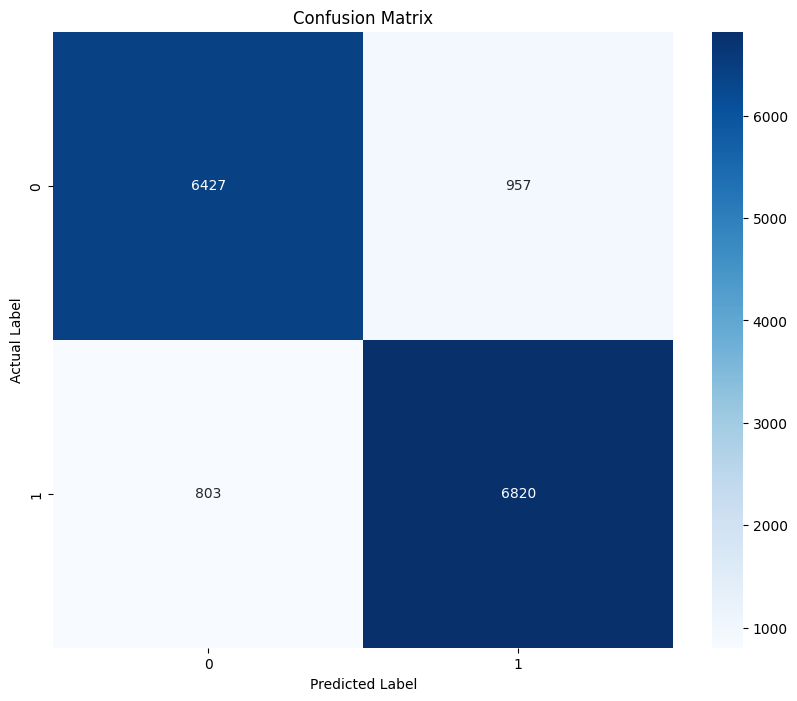

In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [34]:
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_0 (QDense)            (None, 128)               1664      
                                                                 
 act_0 (QActivation)         (None, 128)               0         
                                                                 
 bn_0 (QBatchNormalization)  (None, 128)               512       
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (QDense)            (None, 128)               16512     
                                                                 
 act_1 (QActivation)         (None, 128)               0   

In [35]:
from tensorflow.keras.utils import plot_model


# plot_model(model, to_file='model.dot', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)


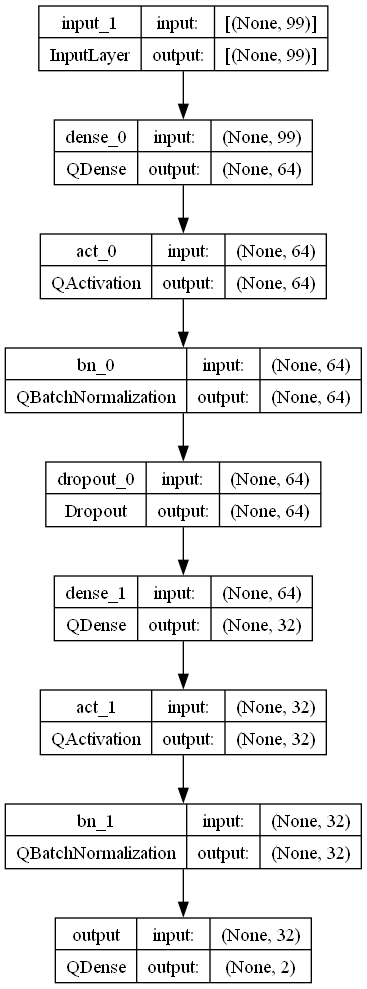

In [36]:
from IPython.display import Image


Image(filename='model.png')


In [37]:
print("TensorBoard log directory:", log_dir)



TensorBoard log directory: logs\fit\20240321-153328
